# **Projet 5 - <span style="color:#1d479b">Segmentez les clients d'un site e-commerce</span>**
---

**<span style="color:#1d479b">Objectif de la mission:</span>**
* Fournir une **segmentation des clients** afin d'apporter des informations supplémentaires aux équipes pour leurs campagnes de communication.
* **Comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles.
* Fournir une **description actionable de la segmentation** et de sa logique sous-jacente pour une utilisation optimale.
* Proposition de **contrat de maintenance basée sur une analyse de la stabilité** des segments au cours du temps..

## **0. Importation des librairies et des données**
---

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# ---
#scikit-learn
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
#classe pour l'ACP
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.metrics import davies_bouldin_score, silhouette_score, adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN
#Classes pour le clustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
path_customers = "C:/Users/remid/Documents/_OC_ParcoursDataScientist/P5_Segmentez_Des_Clients_Dun_Site_e_commerce/df_maintenance.csv"
df_maintenance = pd.read_csv(path_customers, sep=",")
df = df_maintenance.copy()

### **0.1 - Définition de la charte graphique**

In [3]:
["#00317a","#1d479b","#FFF","#F1F1F1","#333","#000"]

['#00317a', '#1d479b', '#FFF', '#F1F1F1', '#333', '#000']

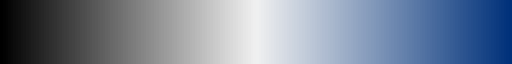

In [4]:
# Define the heatmap color
first_color = "#000"
under_color = "#F1F1F1"
over_color = "#00317a"
# Create a personal color map 
colors = [first_color,under_color, over_color]
n_bins = 200
cmap_name = 'custom_colormap'
heatmap_color = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
heatmap_color

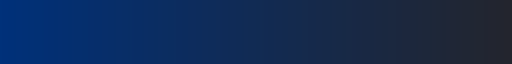

In [5]:
palette_b = sns.dark_palette("#00317a", reverse=True, as_cmap=True)
palette_b

In [6]:
# Colour palette for the various graphics
n_colors = 10
palette_map = sns.color_palette("dark:#00317a", n_colors=n_colors,as_cmap=False)
palette_map

[(0.13938124775110491, 0.14652229085327886, 0.17972974582003676),
 (0.12407664015490516, 0.15153314580610608, 0.2125283558138074),
 (0.1087720325587054, 0.15654400075893327, 0.2453269658075781),
 (0.09292083183406995, 0.1617338148172186, 0.27929695472969773),
 (0.0776162242378702, 0.1667446697700458, 0.3120955647234684),
 (0.06176502351323472, 0.17193448382833112, 0.346065553645588),
 (0.04646041591703498, 0.1769453387811583, 0.37886416363935865),
 (0.030609215192399508, 0.18213515283944365, 0.41283415256147826),
 (0.015304607596199768, 0.18714600779227084, 0.4456327625552489),
 (0.0, 0.19215686274509805, 0.47843137254901963)]

### **0.2 - Normalisation de l'affichage des graphiques**

In [7]:
# Defines display options for rows and columns
pd.set_option('display.max_row',100)
pd.set_option('display.max_column',100)

In [8]:
# Defines title formatting
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titlecolor'] = '#000'
plt.rcParams['axes.titlepad'] = 20
# Defines axis formatting
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelcolor'] = '#000'
#Defines scale formatting
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['xtick.color'] = '#333'
plt.rcParams['ytick.color'] = '#333'

In [9]:
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.2,
              rc={"axes.titlesize":16, 
                  "axes.labelsize":10, 
                  "xtick.labelsize":8, 
                  "ytick.labelsize":8, 
                  "xtick.color":"#333", 
                  "ytick.color":"#333", 
                  "axes.titlecolor":"#000", 
                  "axes.labelcolor":"#000"
                  })

## **1. Traitement des données**
***

In [10]:
df_nb_orders_per_customer = df.groupby(by="customer_unique_id").count()[["order_id"]].reset_index()
df_nb_orders_per_customer.rename(columns={"order_id":"nb_orders_per_customer"}, inplace=True)

In [11]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['year_month'] = df['order_purchase_timestamp'].dt.to_period('M')

In [12]:
df.sort_values('year_month', inplace=True)

In [13]:
# Convertir 'year_month' en datetime
df['year_month'] = df['year_month'].dt.to_timestamp()

In [14]:
df.drop(columns=["order_id","order_delivered_customer_date","customer_zip_code_prefix","customer_city","days_since_last_order"], inplace=True)

## **2. Clustering**
***

In [ ]:
data_6m = df[df['year_month'] < df['year_month'].min() + pd.DateOffset(months=6)]
data_6m = data_6m.groupby(by="customer_unique_id").mean().reset_index().dropna()
data_6m = data_6m.merge(df_nb_orders_per_customer, on="customer_unique_id", how="left")
# Calculate the number of days elapsed
data_6m['days_since_last_order'] = (data_6m["order_purchase_timestamp"].max() - data_6m['order_purchase_timestamp']).dt.days

data_6m = data_6m.loc[:,["review_score", "payment_installments", "average_price", "days_since_last_order", "nb_orders_per_customer"]]

sc_6m = StandardScaler()
data_6m_scaled = sc_6m.fit_transform(data_6m)

kmeans_6m = KMeans(n_clusters=5, n_init="auto", random_state=42)  # vous pouvez changer le nombre de clusters en fonction de vos besoins
kmeans_6m.fit(data_6m_scaled)
clusters = kmeans_6m.labels_

In [ ]:
data_8m = df[df['year_month'] < df['year_month'].min() + pd.DateOffset(months=8)]
data_8m = data_8m.groupby(by="customer_unique_id").mean().reset_index().dropna()
data_8m = data_8m.merge(df_nb_orders_per_customer, on="customer_unique_id", how="left")
# Calculate the number of days elapsed
data_8m['days_since_last_order'] = (data_8m["order_purchase_timestamp"].max() - data_8m['order_purchase_timestamp']).dt.days

data_8m = data_8m.loc[:,["review_score", "payment_installments", "average_price", "days_since_last_order", "nb_orders_per_customer"]]

sc_8m = StandardScaler()
data_8m_scaled = sc_8m.fit_transform(data_8m)

kmeans_8m = KMeans(n_clusters=5, n_init="auto", random_state=42)  # vous pouvez changer le nombre de clusters en fonction de vos besoins
kmeans_8m.fit(data_8m_scaled)
clusters_8m = kmeans_8m.labels_

In [ ]:
data_scaled = sc_6m.fit_transform(data_8m)

adjusted_rand_score(kmeans_6m.predict(data_scaled),clusters_8m)

In [ ]:
data_10m = df[df['year_month'] < df['year_month'].min() + pd.DateOffset(months=10)]
data_10m = data_10m.groupby(by="customer_unique_id").mean().reset_index().dropna()
data_10m = data_10m.merge(df_nb_orders_per_customer, on="customer_unique_id", how="left")
# Calculate the number of days elapsed
data_10m['days_since_last_order'] = (data_10m["order_purchase_timestamp"].max() - data_10m['order_purchase_timestamp']).dt.days

data_10m = data_10m.loc[:,["review_score", "payment_installments", "average_price", "days_since_last_order", "nb_orders_per_customer"]]

sc_10m = StandardScaler()
data_10m_scaled = sc_10m.fit_transform(data_10m)

kmeans_10m = KMeans(n_clusters=5, n_init="auto", random_state=42)  # vous pouvez changer le nombre de clusters en fonction de vos besoins
kmeans_10m.fit(data_10m_scaled)
clusters_10m = kmeans_10m.labels_

In [ ]:
data_scaled = sc_8m.fit_transform(data_10m)

adjusted_rand_score(kmeans_8m.predict(data_scaled),clusters_10m)

In [31]:
df['year_month'].unique()

<DatetimeArray>
['2016-09-01 00:00:00', '2016-10-01 00:00:00', '2016-12-01 00:00:00',
 '2017-01-01 00:00:00', '2017-02-01 00:00:00', '2017-03-01 00:00:00',
 '2017-04-01 00:00:00', '2017-05-01 00:00:00', '2017-06-01 00:00:00',
 '2017-07-01 00:00:00', '2017-08-01 00:00:00', '2017-09-01 00:00:00',
 '2017-10-01 00:00:00', '2017-11-01 00:00:00', '2017-12-01 00:00:00',
 '2018-01-01 00:00:00', '2018-02-01 00:00:00', '2018-03-01 00:00:00',
 '2018-04-01 00:00:00', '2018-05-01 00:00:00', '2018-06-01 00:00:00',
 '2018-07-01 00:00:00', '2018-08-01 00:00:00', '2018-09-01 00:00:00']
Length: 24, dtype: datetime64[ns]

In [38]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score

# Supposons que df est votre DataFrame et df_nb_orders_per_customer est une autre DataFrame

# Obtenir le nombre total de mois dans les données
total_months = len(df['year_month'].unique())

# Initialiser un DataFrame pour stocker les scores ARI pour chaque mois
ari_df = pd.DataFrame(columns=['year_month', 'ARI_score'])

# Itérer sur la plage de mois
for month in range(6, total_months, 1):
    # Créer un sous-ensemble de données pour le mois actuel
    data_m = df[df['year_month'] < df['year_month'].min() + pd.DateOffset(months=month)]
    data_m = data_m.groupby(by="customer_unique_id").mean().reset_index().dropna()
    data_m = data_m.merge(df_nb_orders_per_customer, on="customer_unique_id", how="left")
    data_m['days_since_last_order'] = (data_m["order_purchase_timestamp"].max() - data_m['order_purchase_timestamp']).dt.days

    data_m = data_m.loc[:,["review_score", "payment_installments", "average_price", "days_since_last_order", "nb_orders_per_customer"]]

    # Mettre à l'échelle les données
    sc_m = StandardScaler()
    data_m_scaled = sc_m.fit_transform(data_m)

    # Ajuster un modèle KMeans
    kmeans_m = KMeans(n_clusters=5, n_init="auto", random_state=42)
    kmeans_m.fit(data_m_scaled)
    clusters_m = kmeans_m.labels_

    # Calculer le score ARI si ce n'est pas le premier mois
    if month > 6:
        data_scaled = sc_prev.fit_transform(data_m)
        ari_score = adjusted_rand_score(kmeans_prev.predict(data_scaled),clusters_m)

        # Ajouter le score ARI au DataFrame
        new_row = pd.DataFrame({'year_month': [month], 'ARI_score': [ari_score]})
        ari_df = pd.concat([ari_df, new_row], ignore_index=True)

    # Mettre à jour les variables pour le prochain tour de boucle
    kmeans_prev = kmeans_m
    sc_prev = sc_m

<Axes: ylabel='ARI_score'>

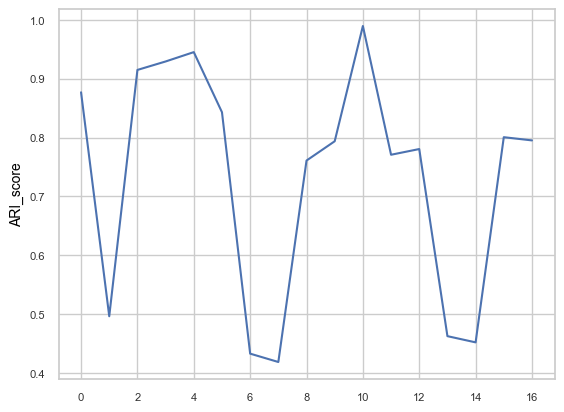

In [40]:
sns.lineplot(ari_df["ARI_score"])